# Transformer Base ChatBot From Scratch

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/NLP-Projects-CAP6640/Project3-ChatBot">View source on GitHub</a>
  </td>
</table>

## Loading libraries

In [2]:
!pip install protobuf==3.20.3

Defaulting to user installation because normal site-packages is not writeable


In [45]:
import transformers
import os
import numpy as np
import codecs
import tensorflow as tf
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import re
import warnings
import tensorflow_datasets as tfds
import tensorflow as tf
import joblib
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Progbar
warnings.filterwarnings('ignore')

## Loading Data Set

We have used the cornel movies data set  [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).  This dataset has 200,000  conversational exbetween 10,000 actots and characters.

`movie_conversations.txt` has  list of the conversation IDs 
`movie_lines.text` has the dialog correspoding with each conversation ID. 


In [46]:
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus"
)

path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

### GPU / TPU initialization

`TPU` or `GPU` 

In [47]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


### preprocess data

Due to hardware limitation we kepts the `MAX_SAMPLES=25000` and the maximum length `MAX_LENGTH=40`.

Below is our data processing steps:




* 1) Extract `MAX_SAMPLES` and prepare `questions` and `answers`.

In [48]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

* 2. Preprocess senteces by removing punctuatons etc.

In [49]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence


def load_conversations():
    # dictionary of line id to text
    id2line = {}
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()
    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        # get conversation in a list of line ID
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs
    return inputs, outputs


questions, answers = load_conversations()

In [51]:
print(f"Sample question: {questions[100]}")
print(f"Sample answer: {answers[100]}")

Sample question: you set me up .
Sample answer: i just wanted


* 3. Build tokenizer (map our text to ID and ID to text so we can feed it to our tranformer) 

In [52]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [53]:
print(f"Tokenized sample : {tokenizer.encode(questions[100])}")

Tokenized sample : [5, 525, 36, 116, 1]


* 4. Add `START_TOKEN` and `END_TOKEN` to indicate the start and end of each sentence (this is for our tranformer to undersrand start and end of sentences).
* 5. Trim the sentence that has more than `MAX_LENGTH` tokens.
* 6. Pad out tokenized sentences to `MAX_LENGTH`

In [54]:
# Tokenize, trim and pad sentences
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # tokenize sentence
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        # check tokenized sentence max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs


questions, answers = tokenize_and_filter(questions, answers)

In [55]:
print(f"All Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

All Vocab size: 8279
Number of samples: 44131


### Create Dataset:

In [56]:
# remove End_Token from qyestions
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

## Parameters

Due to harware limitation we adjusted values from the the [paper](https://arxiv.org/abs/1706.03762) 
 num_layers, 
 d_model, 
 units* 
 Have all been reduced

In [57]:
# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

EPOCHS = 40



## Attention Block



### Dot product 

Upon review of the paper the attention is nothing but the scaled dot-product of  Q (query), K (key), V (value). usinf the below:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

Softmax normalizes `key`, So we can know how importnat is this key to its given `query`.

The output is the multiplication of what we got as  attention weights and the `value` vector. 

The dot-product attention is scaled by a factor of square root of the d_model.


In [58]:
def attention_do_product(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention
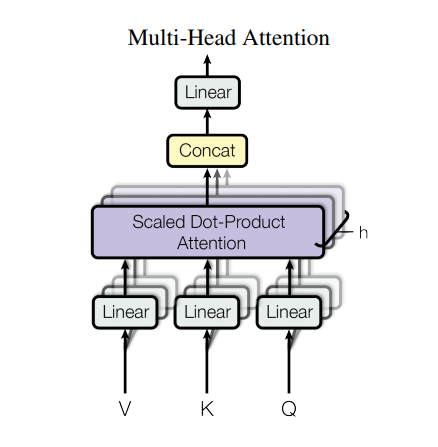

Multi-head attention has 4 parts:
* Linear layers and split into heads.
* dot-product attention.
* Concatenation of all heads.
* Final linear layer.

Each multi-head attention gets a copy of  Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 



In [59]:
class MultiHead(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHead, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHead, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = attention_do_product(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer Architect

### Masking



Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [60]:
def Pad_Mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

Look-ahead mask for example To predict the 5th word, only the first 4 wrds word will be used we will mask the ones after the 5th

In [61]:
def Mask_lookAhead(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = Pad_Mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding

The positional encoding vector is added to the embedding vector. After adding the positional encoding, words will be closer to each other based on their position in the sentence.

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [62]:
class PostionalFunction(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PostionalFunction, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PostionalFunction, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

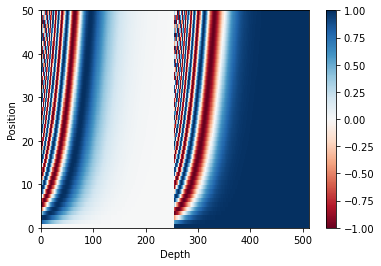

In [63]:
PE = PostionalFunction(50, 512, name="sample_pos_encoding")

plt.pcolormesh(PE.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

### Encoder

Each encoder layer has 2 layers

1. Multi-head attention 
2. 2 dense layers + dropout

Each layer then normalizes and a residual of the layer before gets added to it

In [64]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHead(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [98]:
# conda install -c anaconda python-graphviz


In [99]:
# sample_encoder_layer = encoder_layer(
#     units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder_layer"
# )




# tf.keras.utils.plot_model(
#     sample_encoder_layer, to_file="encoder.png", show_shapes=True
# )

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   x encoder layers 9.  x is number of layers of encoder will add


In [66]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PostionalFunction(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [67]:
sample_encoder = encoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_encoder",
)

# tf.keras.utils.plot_model(sample_encoder, to_file="encoder.png", show_shapes=True)

### Decoder Layer

 decoder layer has the following sub layers:

1.   Masked multi-head attention
2.   Multi-head attention 
3.   2 dense layers followed by dropout

Each layer then normalizes and a residual of the layer before gets added to it

In [68]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHead(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHead(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [69]:
sample_decoder_layer = decoder_layer(
    units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_decoder_layer"
)

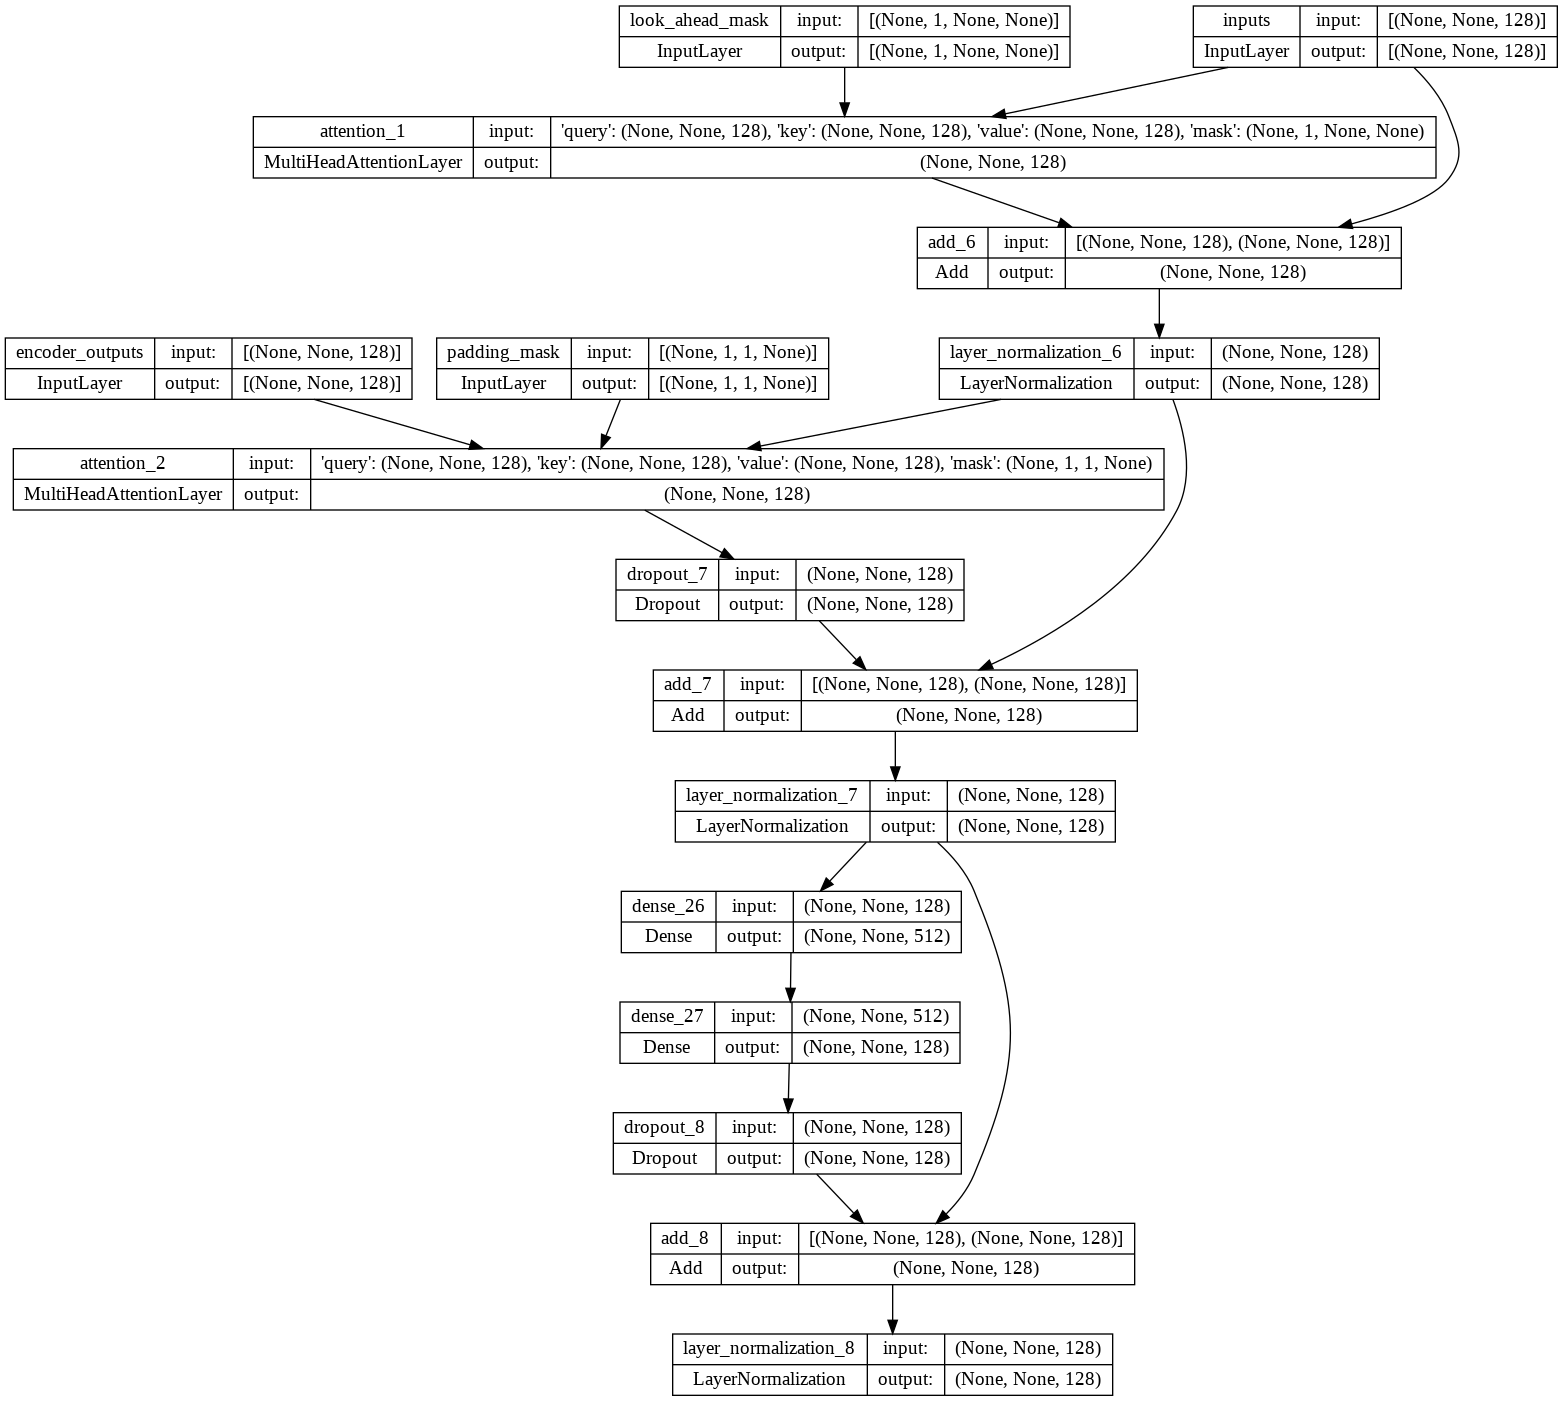

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [70]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PostionalFunction(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

In [71]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder",
)

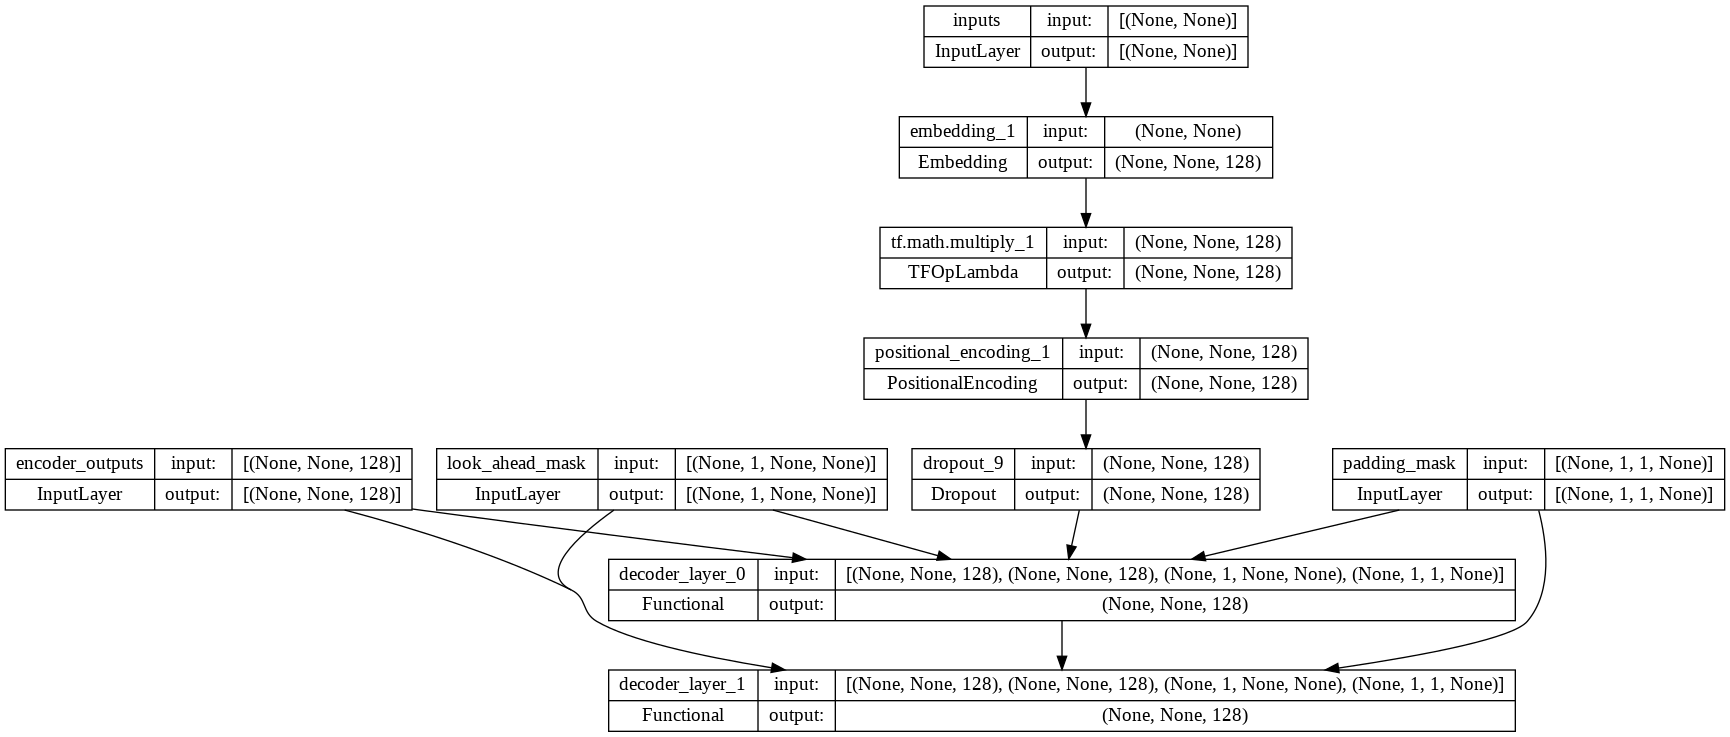

### Transformer

Transformer consists of the encoder + decoder +  final linear layer. 

In [72]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        Pad_Mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        Mask_lookAhead, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        Pad_Mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [73]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer",
)

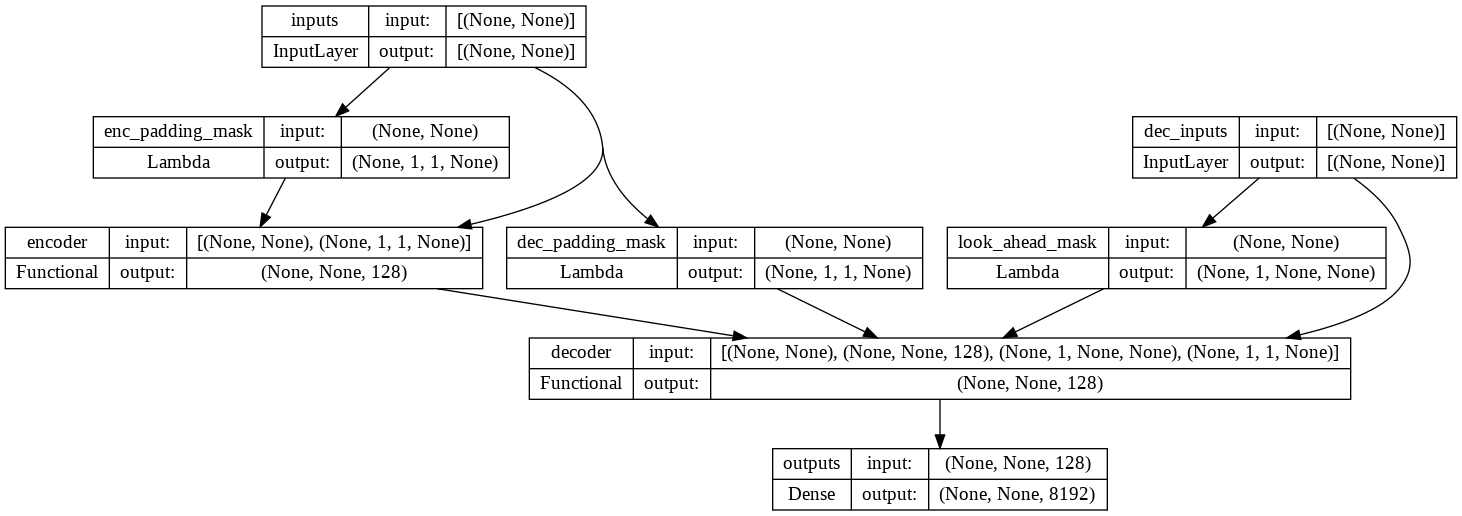

## Training

### Loss function

In [74]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Learning rate

According to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [75]:
class LearningRateMaker(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateMaker, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

Text(0.5, 0, 'Train Step')

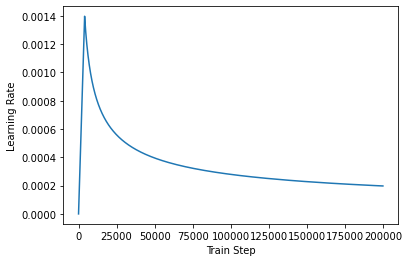

In [76]:
sample_learning_rate = LearningRateMaker(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

###  Model

In [77]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = LearningRateMaker(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)


def accuracy(y_true, y_pred):

    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 256)    3173632     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit model

calling `model.fit()`

In [39]:
model.fit(dataset, epochs=EPOCHS)

Epoch 1/40


690/690 [==============================] - 229s 322ms/step - loss: 2.0987 - accuracy: 0.0426
Epoch 2/40
690/690 [==============================] - 220s 319ms/step - loss: 1.4936 - accuracy: 0.0777
Epoch 3/40
690/690 [==============================] - 218s 316ms/step - loss: 1.3914 - accuracy: 0.0847
Epoch 4/40
690/690 [==============================] - 218s 315ms/step - loss: 1.3330 - accuracy: 0.0891
Epoch 5/40
690/690 [==============================] - 217s 315ms/step - loss: 1.2813 - accuracy: 0.0932
Epoch 6/40
690/690 [==============================] - 218s 315ms/step - loss: 1.2358 - accuracy: 0.0968
Epoch 7/40
690/690 [==============================] - 219s 317ms/step - loss: 1.1812 - accuracy: 0.1010
Epoch 8/40
690/690 [==============================] - 218s 316ms/step - loss: 1.1214 - accuracy: 0.1064
Epoch 9/40
690/690 [==============================] - 218s 316ms/step - loss: 1.0664 - accuracy: 0.1117
Epoch 10/40
690/690 [==============================] - 218s 316ms/step - lo

### Save and use Model

In [82]:
filename = "model.h5"
tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [41]:
# del model
# tf.keras.backend.clear_session()

In [91]:
filename = "model.h5"
model = tf.keras.models.load_model(
    filename,
    custom_objects={
        "PositionalEncoding": PostionalFunction,
        "MultiHeadAttentionLayer": MultiHead,
    },
    compile=False,
)

## Evaluation

In [92]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

## Testing

In [93]:
predict("Where should we eat tonight?")

'that is the problem .'

In [94]:
predict("It's a beautoful day")

'the truth hurts .'

In [95]:
# feed the model with its previous output
sentence = "I feel so sick, I think I should see a doctor"
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = predict(sentence)
    print(f"Output: {sentence}\n")

Input: I feel so sick, I think I should see a doctor


Output: it is a full moon . we only got enough good hours pre nup .

Input: it is a full moon . we only got enough good hours pre nup .
Output: fine . i will just wait here .

Input: fine . i will just wait here .
Output: i will not stand for it .

Input: i will not stand for it .
Output: you are a good man .

Input: you are a good man .
Output: what ?



## Summary and Concolusion
